In [740]:
import requests
from fake_useragent import UserAgent
import random
import time
from bs4 import BeautifulSoup
from tqdm import tqdm

import pandas as pd

from nltk.tokenize import sent_tokenize, word_tokenize
from string import punctuation
import re
import pymorphy2

from collections import Counter

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

from gensim.models import Word2Vec
import nltk
from nltk.corpus import stopwords

from sklearn.metrics.pairwise import cosine_similarity

In [469]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ann\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Загрузка данных

In [205]:
session = requests.session()
adapter = requests.adapters.HTTPAdapter(
    pool_connections=10, # Количество пулов соединений
    pool_maxsize=10 # Размер каждого пула
)
session.mount('https://', adapter)
ua = UserAgent()
headers = {'User-Agent': ua.random}
proxy = ['45.8.107.56',
        '172.64.103.77',
        '66.235.200.132']
proxies = {'http': f'http://{proxy[random.randrange(0,3)]}'}

In [241]:
good_reviews = []
bad_reviews = []
# сначала качаем отзывы со страницы с отметками 1, потом качаем отзывы с отметками 5
for ct in tqdm(range(1,4)):
    link = f'https://infodoctor.ru/reviews?mark=1&type=written&page={ct}'
    response = session.get(link,
                           headers=headers,
                           proxies=proxies)
    time.sleep(random.uniform(1.1, 5.2))
    soup = BeautifulSoup(response.text, 'html.parser')
    for review in soup.find_all(class_='review__text'):
        bad_reviews.append(review.text.strip())
time.sleep(random.uniform(3, 5.2))
for ct in tqdm(range(1,4)):
    link = f'https://infodoctor.ru/reviews?mark=5&type=written&page={ct}'
    response = session.get(link,
                           headers=headers,
                           proxies=proxies)
    time.sleep(random.uniform(1.1, 5.2))
    soup = BeautifulSoup(response.text, 'html.parser')
    for review in soup.find_all(class_='review__text'):
        good_reviews.append(review.text.strip())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:16<00:00,  5.51s/it]


Пусть 0 -- плохой отзыв, а 1 -- хороший отзыв

In [266]:
review_dict = {'review': [],
              'rating': []}
for review in good_reviews:
    # на всякий случай, вдруг есть дубликаты
    if review not in review_dict:
        review_dict['review'].append(review)
        review_dict['rating'].append(1)
for review in bad_reviews:
    # на всякий случай, вдруг есть дубликаты
    if review not in review_dict:
        review_dict['review'].append(review)
        review_dict['rating'].append(0)

In [273]:
data = pd.DataFrame(review_dict)
data

,review,rating
0,Хочу поблагодарить доктора за качественную кон...,1
1,Я побывала в клинике Здравствуй на м. Беговой ...,1
2,Недавно мне пришлось обратиться за медицинской...,1
3,Проходила лечение в клинике на юго-западной и ...,1
4,"Обращалась в пнд за помощью, попала к этому до...",1
...,...,...
85,"Прийдя на прием к Елене, сразу отправила в дис...",0
86,Доктор считает допустимы в своём заключении дл...,0
87,Моему мужу Аксенов удалял грыжу на позвоночник...,0
88,Доктору не интересно вылечить пациента. Ему го...,0


In [246]:
# на всякий случай экспортируем полученные данные

In [269]:
data.to_csv('reviews.csv',index=False)

In [270]:
# перемешиваем

In [277]:
data = data.sample(frac=1)

# Токенизируйте слова, приведите их к нижнему регистру и к начальной форме

In [282]:
morph = pymorphy2.MorphAnalyzer()

In [640]:
def make_clear_text(text):
    text = text.lower()
    text = re.sub(r"\.(?=[^ ])", ". ", text, 0, re.MULTILINE)
    text = re.sub(r"\d", "", text, 0, re.MULTILINE)
    new_text = []
    for word in word_tokenize(text):
        if word not in punctuation:
            if len(word) > 1:
                lemma = morph.parse(word)[0].normal_form
                if lemma not in stopwords.words('russian'):
                    # не будем включать имена
                    if 'Name' not in morph.parse(word)[0].tag:
                        if 'Patr' not in morph.parse(word)[0].tag:
                            if 'Surn' not in morph.parse(word)[0].tag:
                                if len(word) > 2:
                                    new_text.append(lemma)
    new_text = ' '.join(new_text)
    return new_text
# пример
data.iloc[2].review, make_clear_text(data.iloc[2].review)

('Якубсон Виктор Михайлович очень талантливый врач. На приеме 20.09 было очень комфортно. Человек с юмором. Видео, что врач опытный.У меня боль в пояснице, пришла с этой проблемой. Буду делать стельки, пройду реабилитацию по лечебной физкультуре, сделаю узи. Буду лечиться у Виктора Михайловича, потому что вызывает доверие.',
 'якубсон очень талантливый врач приём очень комфортно человек юмор видео врач опытный боль поясница прийти проблема делать стелька пройда реабилитация лечебный физкультура сделать узи лечиться вызывать доверие')

In [641]:
data['clean'] = data.review.apply(make_clear_text)

# Составьте 2 множества - в одном будут слова, которые встречаются только в положительных отзывах, а в другом - встречающиеся только в отрицательных

Разделила на обучающие и тестируемые данные

In [642]:
data_train = pd.concat([data[data.rating == 1].sample(frac=0.85), data[data.rating == 0].sample(frac=0.85)])

In [624]:
# смотрим, что соотношение равное
data_train[data_train.rating == 1].__len__(), data_train[data_train.rating == 0].__len__()

(38, 38)

In [643]:
data_test = data[~data.review.isin(data_train.review.to_list())]

In [626]:
# смотрим, что соотношение равное
data_test[data_test.rating == 1].__len__(), data_test[data_test.rating == 0].__len__()

(7, 7)

In [644]:
all_good_text = ' '.join(data_train[data_train.rating == 1].clean.to_list()).split()
all_bad_text = ' '.join(data_train[data_train.rating == 0].clean.to_list()).split()

In [645]:
good_words = []
bad_words = []
for word in all_good_text+all_bad_text:
    if word in all_good_text:
        if word not in all_bad_text:
            good_words.append(word)
    elif word in all_bad_text:
        if word not in all_good_text:
            bad_words.append(word)

In [646]:
counter_good = Counter(good_words)
counter_bad = Counter(bad_words)
good_words_final = []
bad_words_final = []
for word in counter_good:
    if counter_good[word] > 2:
        good_words_final.append(word)
for word in counter_bad:
    if counter_bad[word] > 2:
        bad_words_final.append(word)

# Создайте функцию, которая будет определять, положительный ли отзыв или отрицательный в зависимости от того, какие слова встретились в нём, и посчитайте качество при помощи accuracy

In [647]:
def choose_polarity(text):
    dict_good = {}
    dict_bad = {}
    for word in text.split():
        if word in good_words_final:
            if word not in dict_good:
                dict_good[word] = 1
            else:
                dict_good[word] += 1
        if word in bad_words_final:
            if word not in dict_bad:
                dict_bad[word] = 1
            else:
                dict_bad[word] += 1
    if sum(dict_good.values()) >= sum(dict_bad.values()):
        # хороший отзыв
        polarity = 1
    else:
        # плохой отзыв
        polarity = 0
    return polarity
print(f'predicted: {choose_polarity(data_test.clean.iloc[1])}')
print(f'real rating: {data_test.rating.iloc[1]}')

predicted: 1
real rating: 1


In [648]:
data_test['predicted'] = data_test.clean.apply(choose_polarity)

C:\Users\Ann\AppData\Local\Temp\ipykernel_7900\1469754905.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['predicted'] = data_test.clean.apply(choose_polarity)


In [649]:
accuracy_score(data_test.rating,data_test['predicted'])

0.8571428571428571

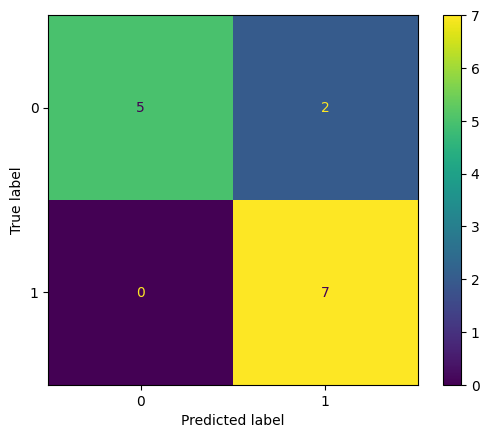

In [650]:
ConfusionMatrixDisplay(confusion_matrix(data_test.rating,data_test['predicted'])).plot()

# Предложите как минимум 2 способа улучшить этот алгоритм определения тональности отзыва (1 балл за описание и реализацию каждого способа; если 2 способа описаны только текстом, это 1 балл. За третий и последующие способы дополнительных баллов не будет)

Я приведу больше 2 способов, так как не уверена, что некоторые способы будут засчитаны, ведь они неудачны

## Способ 1

Смотрим не просто на то, есть ли слово из списка "хороших" или "плохих", а посложнее.

Смотрим на Х% самых частотных слов в тексте. Далее считаем, больше ли в них "хороших" слов или "плохих". Кого больше, такая и будет тональность. Посмотрим на разные Х, чтобы понять, какой из них лучше

In [653]:
def choose_polarity_1(text, percent):
    good = 0
    bad = 0
    count = Counter(text.split()).most_common(round(percent*len(text.split())))
    for most_common in count:
        if most_common[0] in good_words_final:
            good += 1
        if most_common[0] in bad_words_final:
            bad += 1
    if good >= bad:
        return 1
    else:
        return 0
print(f'predicted: {choose_polarity_1(data_test.clean.iloc[0], 0.25)}')
print(f'real rating: {data_test.rating.iloc[0]}')

predicted: 1
real rating: 1


<AxesSubplot: xlabel='percent'>

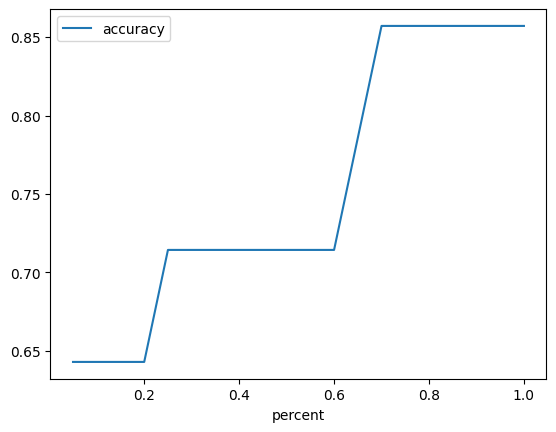

In [652]:
X = [0.05, 0.10, 0.20, 0.25, 0.30, 0.40, 0.50, 0.6, 0.7, 0.8, 1]
Y = []
for percent in X:
    predicted = data_test.clean.apply(choose_polarity_1, percent=percent)
    Y.append(accuracy_score(data_test.rating, predicted))
pd.DataFrame({'percent': X,
             'accuracy': Y}).plot(x='percent', y='accuracy')

Итак, видно, что больше 0.85 мы не уйдем. Именно такой же результат нам показывал прошлый вариант анализа

## Способ 2

Оценку часто выражают прилагательные и наречия. Составим словарь с частотностями уникальных для тональности прил&наречий. Далее будем считать число входящих в текст уникальных для тональности слов так, что чем частотнее слово было в словаре уникальных слов, тем больше значения она будет иметь. То есть будем суммировать не просто:

если "хорошее" слово в тексте => +1 к сумме "хороших" слов

а

если "хорошее" слово в тексте => +(частотность слова в словаре/сумма частотностей слов в словаре) к сумме "хороших" слов

In [678]:
good_adj = []
bad_adj = []
for word in good_words:
    if morph.parse(word)[0].tag.POS in ['ADVB','ADJF']:
        good_adj.append(word)
for word in bad_words:
    if morph.parse(word)[0].tag.POS in ['ADVB','ADJF']:
        bad_adj.append(word)
        
good_adj_final = {}
bad_adj_final = {}
for word in Counter(good_adj):
    if Counter(good_adj)[word] > 2:
        good_adj_final[word] = Counter(good_adj)[word]
for word in Counter(bad_adj):
    if Counter(bad_adj)[word] > 2:
        bad_adj_final[word] = Counter(bad_adj)[word]

In [684]:
def choose_polarity_2(text):
    good = 0
    bad = 0
    for word in text.split():
        if word in good_adj_final:
            good += good_adj_final[word]/sum(good_adj_final.values())
        if word in bad_adj_final:
            bad += bad_adj_final[word]/sum(bad_adj_final.values())
    if good >= bad:
        return 1
    else:
        return 0
print(f'predicted: {choose_polarity_2(data_test.clean.iloc[0])}')
print(f'real rating: {data_test.rating.iloc[0]}')

predicted: 1
real rating: 1


In [686]:
predicted = data_test.clean.apply(choose_polarity_2)
accuracy_score(data_test.rating, predicted)

0.5714285714285714

Способ неудачный, точность понизилась

## Способ 3: просто добавь ~~воды~~ данных

Оригинальный алгоритм очень неустойчиво работает на небольшом массиве данных: это можно заметить, даже когда меняешь тестовую/обучающую выборки данных. Поэтому чтобы улучшить качество этого алгоритма, нужно собрать больше текста. Далее проделаем те же действия, что раньше

In [687]:
session = requests.session()
adapter = requests.adapters.HTTPAdapter(
    pool_connections=10, # Количество пулов соединений
    pool_maxsize=10 # Размер каждого пула
)
session.mount('https://', adapter)
ua = UserAgent(verify_ssl=False)
headers = {'User-Agent': ua.random}
proxy = ['80.179.140.189',
        '102.132.48.60',
        '172.67.128.116']
proxies = {'http': f'http://{proxy[random.randrange(0,3)]}'}

In [688]:
other_good_reviews = []
other_bad_reviews = []
# сначала качаем отзывы со страницы с отметками 1, потом качаем отзывы с отметками 5
for ct in tqdm(range(4,8)):
    link = f'https://infodoctor.ru/reviews?mark=1&type=written&page={ct}'
    response = session.get(link,
                           headers=headers,
                           proxies=proxies)
    time.sleep(random.uniform(1.1, 5.2))
    soup = BeautifulSoup(response.text, 'html.parser')
    for review in soup.find_all(class_='review__text'):
        other_bad_reviews.append(review.text.strip())
time.sleep(random.uniform(3, 5.2))
for ct in tqdm(range(4,8)):
    link = f'https://infodoctor.ru/reviews?mark=5&type=written&page={ct}'
    response = session.get(link,
                           headers=headers,
                           proxies=proxies)
    time.sleep(random.uniform(1.1, 5.2))
    soup = BeautifulSoup(response.text, 'html.parser')
    for review in soup.find_all(class_='review__text'):
        other_good_reviews.append(review.text.strip())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:18<00:00,  4.55s/it]


In [700]:
review_dict = {'review': [],
              'rating': []}
for review in other_good_reviews:
    # на всякий случай, вдруг есть дубликаты
    if review not in review_dict:
        review_dict['review'].append(review)
        review_dict['rating'].append(1)
for review in other_bad_reviews:
    # на всякий случай, вдруг есть дубликаты
    if review not in review_dict:
        review_dict['review'].append(review)
        review_dict['rating'].append(0)
        
bigger_data = pd.DataFrame(review_dict)
bigger_data = pd.concat([bigger_data,data])
bigger_data.sample(frac=1)

bigger_data['clean'] = bigger_data.review.apply(make_clear_text)

In [706]:
data_train = pd.concat([bigger_data[bigger_data.rating == 1].sample(frac=0.85), bigger_data[bigger_data.rating == 0].sample(frac=0.85)])
data_test = bigger_data[~bigger_data.review.isin(data_train.review.to_list())]
all_good_text = ' '.join(data_train[data_train.rating == 1].clean.to_list()).split()
all_bad_text = ' '.join(data_train[data_train.rating == 0].clean.to_list()).split()

good_words = []
bad_words = []
for word in all_good_text+all_bad_text:
    if word in all_good_text:
        if word not in all_bad_text:
            good_words.append(word)
    elif word in all_bad_text:
        if word not in all_good_text:
            bad_words.append(word)
counter_good = Counter(good_words)
counter_bad = Counter(bad_words)
good_words_final = []
bad_words_final = []
for word in counter_good:
    if counter_good[word] > 2:
        good_words_final.append(word)
for word in counter_bad:
    if counter_bad[word] > 2:
        bad_words_final.append(word)
        
# использовали самый первый, неулучшенный алгоритм 
data_test['predicted'] = data_test.clean.apply(choose_polarity)
accuracy_score(data_test.rating,data_test['predicted'])

C:\Users\Ann\AppData\Local\Temp\ipykernel_7900\770301275.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['predicted'] = data_test.clean.apply(choose_polarity)


0.875

Качество чуть-чуть увеличилось! Попробуем способ 2 применить к этому большому массиву данных

In [707]:
good_adj = []
bad_adj = []
for word in good_words:
    if morph.parse(word)[0].tag.POS in ['ADVB','ADJF']:
        good_adj.append(word)
for word in bad_words:
    if morph.parse(word)[0].tag.POS in ['ADVB','ADJF']:
        bad_adj.append(word)
        
good_adj_final = {}
bad_adj_final = {}
for word in Counter(good_adj):
    if Counter(good_adj)[word] > 2:
        good_adj_final[word] = Counter(good_adj)[word]
for word in Counter(bad_adj):
    if Counter(bad_adj)[word] > 2:
        bad_adj_final[word] = Counter(bad_adj)[word]
predicted = data_test.clean.apply(choose_polarity_2)
accuracy_score(data_test.rating, predicted)

0.6875

По сравнению с прошлым разом качество стало лучше: было 0.57

## Способ 4: Word2Vec

Сейчас, когда у нас побольше данных, можно попробовать обучить на них модель word2vec. Сравним, как она работала бы и при 90 загруженных отзывах, и при 210

In [720]:
def make_text_Word2Vec(list_):
    new_list = []
    words = []
    for review in list_:
        for sentence in sent_tokenize(review):
            for word in make_clear_text(sentence).split():
                if word not in stopwords.words('russian'):
                    words.append(word)
            new_list.append(words)
            words = []
    return new_list

In [721]:
model_little = Word2Vec(make_text_Word2Vec(data.review.to_list()), vector_size=100, window=5, workers=4)

In [723]:
model_big = Word2Vec(make_text_Word2Vec(bigger_data.review.to_list()), vector_size=100, window=5, workers=4)

In [765]:
# слово для примера
check_word = Counter(good_adj).most_common(1)
check_word[0][0]

'внимательный'

In [737]:
model_little.wv.most_similar(check_word[0][0], topn=10)

[('свой', 0.241989865899086),
 ('большой', 0.22373878955841064),
 ('место', 0.18961851298809052),
 ('ребёнок', 0.16938656568527222),
 ('очень', 0.162309929728508),
 ('услуга', 0.15512500703334808),
 ('ждать', 0.15496638417243958),
 ('наш', 0.14880353212356567),
 ('профессиональный', 0.1471921056509018),
 ('приём', 0.1470693200826645)]

In [738]:
model_big.wv.most_similar(check_word[0][0], topn=10)

[('клиника', 0.7162750959396362),
 ('процедура', 0.7055168151855469),
 ('провести', 0.6991151571273804),
 ('анализ', 0.6987566947937012),
 ('это', 0.6956916451454163),
 ('свой', 0.6929165720939636),
 ('всё', 0.6922475099563599),
 ('работа', 0.6895725727081299),
 ('услуга', 0.6885058283805847),
 ('врач', 0.6874463558197021)]

С точки зрения здравого смысла, обе модели работают как-то неправильно. Тем не менее, попробуем улучшить оригинальный алгоритм

Выберем по 10 самых частотных слов в уникальных словарях тональностей. Будем каждое слово в тексте сравнивать косинусной близостью с 10 словами из хорошего словаря и из плохого словаря, далее будем в отдельных переменных складывать все значения косинусной близости. Чем больше близость, тем больше значение косинусной близости. Чья больше сумма в итоге, такая тональность

In [748]:
# пример
cosine_similarity([model_big.wv['работа']], [model_big.wv['врач']])

array([[0.84227216]], dtype=float32)

In [760]:
def choose_polarity_3(text, model):
    good = 0
    bad = 0
    for word in text.split():
        if word in model.wv:
            for good_word in Counter(good_adj).most_common(5):
                good += cosine_similarity([model.wv[word]], [model.wv[good_word[0]]])[0][0]
            for bad_word in Counter(bad_adj).most_common(5):
                bad += cosine_similarity([model.wv[word]], [model.wv[bad_word[0]]])[0][0]
    if good >= bad:
        return 1
    else:
        return 0
print(f'predicted: {choose_polarity_3(data_test.clean.iloc[1],model_big)}')
print(f'real rating: {data_test.rating.iloc[1]}')

predicted: 0
real rating: 1


In [758]:
predicted = data_test.clean.apply(choose_polarity_3, model=model_big)
accuracy_score(data_test.rating, predicted)

0.5

Как видно, даже использование обученной на более большом массиве данных модели word2vec недостаточно, чтобы добиться хорошей точности

## Способ 5

Посмотрим, сложет ли модель word2vec улучшить словарь уникальных хороших и плохих слов. Возьмем 5 самых частотных слов в словаре. Для каждого слова добавляем в словарь 5 ближайших слов из модели

In [785]:
new_good_words = []
new_bad_words = []

for word in Counter(good_adj).most_common(5):
    if word[0] in model_big.wv:
        for sim_word in model_big.wv.most_similar(word[0], topn=5):
            if sim_word[1] >= 0.6:
                new_good_words.append(sim_word[0])
for word in Counter(bad_adj).most_common(5):
    if word[0] in model_big.wv:
        for sim_word in model_big.wv.most_similar(word[0], topn=5):
            if sim_word[1] >= 0.6:
                new_bad_words.append(sim_word[0])

Используем оригинальный алгоритм

In [787]:
def choose_polarity_4(text):
    dict_good = {}
    dict_bad = {}
    for word in text.split():
        if word in new_good_words:
            if word not in dict_good:
                dict_good[word] = 1
            else:
                dict_good[word] += 1
        if word in new_bad_words:
            if word not in dict_bad:
                dict_bad[word] = 1
            else:
                dict_bad[word] += 1
    if sum(dict_good.values()) >= sum(dict_bad.values()):
        # хороший отзыв
        polarity = 1
    else:
        # плохой отзыв
        polarity = 0
    return polarity
print(f'predicted: {choose_polarity_4(data_test.clean.iloc[1])}')
print(f'real rating: {data_test.rating.iloc[1]}')

predicted: 0
real rating: 1


In [789]:
predicted = data_test.clean.apply(choose_polarity_4)
accuracy_score(data_test.rating, predicted)

0.4375

К сожалению, увеличить словарь хороших/плохих слов получилось неудачно